In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import os
import pickle
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("bed_data.csv")

# Convert Date column to datetime (if applicable)
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)

# Select relevant features
features = [
    "Total_Admissions_Today",
    "Total_Discharges_Today",
    "Avg_LOS",
    "Avg_Age_Admissions_Today",
    "Total_Beds_Occupied_Today","Is_Weekend"
]
target = "Total_Beds_Required_Tomorrow"

# Normalize data
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features + [target]] = scaler.fit_transform(df[features + [target]])

# Train-Test Split (80% Train, 20% Test)
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled.iloc[:train_size], df_scaled.iloc[train_size:]

# Function to create sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][features].values)  # Features
        y.append(data.iloc[i+seq_length][target])  # Target
    return np.array(X), np.array(y)

# Prepare sequences
seq_length = 10  # Model looks at last 10 days
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

# Define LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(seq_length, len(features))),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    return model

# Path for saving model as pickle
model_path = "lstm_bed_prediction.pkl"

# Check if model exists, else train a new one
if os.path.exists(model_path):
    with open(model_path, "rb") as f:
        model_json, weights = pickle.load(f)
    model = model_from_json(model_json)  # Load architecture
    model.set_weights(weights)  # Load weights
    model.compile(loss='mse', optimizer='adam')
    print("Loaded existing model.")
else:
    model = build_lstm_model()
    model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)
    
    # Save model as pickle
    model_json = model.to_json()
    weights = model.get_weights()
    with open(model_path, "wb") as f:
        pickle.dump((model_json, weights), f)

    print("Trained and saved new model.")

# Get predictions on the test set
test_predictions_scaled = model.predict(X_test)

# Reverse scale the predictions
test_predictions_full = np.zeros((y_test.shape[0], len(features) + 1))
test_predictions_full[:, -1] = test_predictions_scaled.flatten()
test_predictions = scaler.inverse_transform(test_predictions_full)[:, -1]  # Extract only target column

# Reverse scale actual values
y_test_full = np.zeros((y_test.shape[0], len(features) + 1))
y_test_full[:, -1] = y_test
y_test_actual = scaler.inverse_transform(y_test_full)[:, -1]  # Extract only target column

# Compute R² Score
r2 = r2_score(y_test_actual, test_predictions)
print(f"R² Score: {r2:.4f}")

Epoch 1/100


c:\Users\HARSHDIP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.1144 - val_loss: 4.8039e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0050 - val_loss: 2.5163e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0050 - val_loss: 1.8699e-04
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0028 - val_loss: 9.2511e-04
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - val_loss: 3.8948e-04
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - val_loss: 3.9713e-04
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030 - val_loss: 8.9362e-04
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_loss: 1.9026e-04
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 12/100
36/36 ━━━━━━━━━━━━━

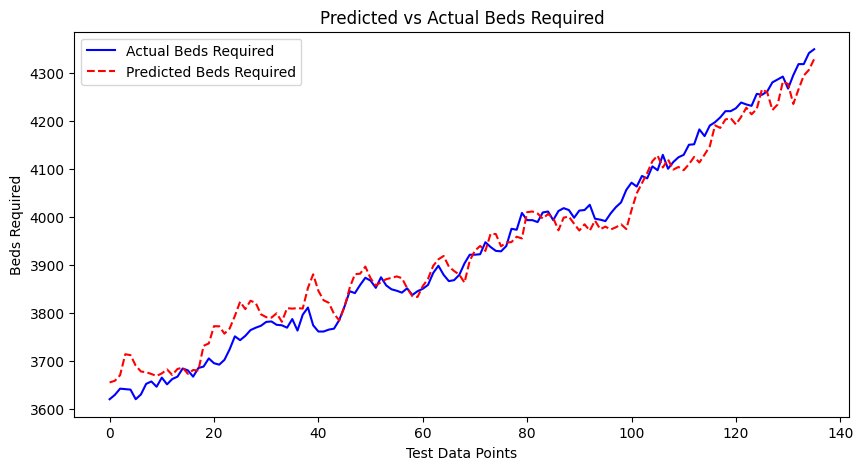

In [31]:
# Plot Predicted vs Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label="Actual Beds Required", color='blue')
plt.plot(test_predictions, label="Predicted Beds Required", color='red', linestyle='dashed')
plt.xlabel("Test Data Points")
plt.ylabel("Beds Required")
plt.title("Predicted vs Actual Beds Required")
plt.legend()
plt.show()


In [32]:
with open(model_path, "wb") as f:
        pickle.dump((model_json, weights), f)

    